In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as opt
import datetime as dt
from pandas_datareader import data as web
%matplotlib inline

Source code reference: https://towardsdatascience.com/python-markowitz-optimization-b5e1623060f5

In [64]:
# Top 5 Market Cap Companies as of 2019-end
tickers = ["AAPL","MSFT","GOOG","AMZN","TSLA","TLT"]

# Start and end date
start = dt.datetime(2019,12,31)
end = dt.datetime(2021,12,31)

# 'd' = daily, 'w' = weekly, 'm' = monthly
interval = 'd'
frequency = {'d':253, 'w':52, 'm': 12} # frequency of compounding

# https://www.bloomberg.com/markets/rates-bonds/government-bonds/us
# Long-term Risk-free rate, 2 Year Treasury Bond Yield
rf = 0.0245

# Import Stocks Data
def get_data(tickers, start, end, interval):
    df = pd.DataFrame()
    for t in tickers:
        df[t] = web.get_data_yahoo(t, start, end, interval=interval)['Adj Close']
        #df[t] = web.DataReader(t, data_source='yahoo',start=start,end=end)['Adj Close']
    df.dropna(inplace=True)
    
    return df

# Calculate Log Returns of the stocks
def log_ret(stocks_data):
    log_return = np.log(stocks_data/stocks_data.shift(1))[1:]
    
    return log_return

# Annualize Log Returns
# Calculate Each Stocks annual Risk & Returns
def stock_riskreturns(log_return):
    s_returns = log_return.mean()*frequency[interval]
    s_risk = log_return.std()*(frequency[interval]**0.5)
    
    return s_risk, s_returns

# Calculate Portfolio annual Risk & Returns
def port_riskreturns(weights,log_return):
    weights = np.array(weights)
    p_returns = np.sum(weights * log_return.mean()*frequency[interval])
    p_risk = np.sqrt(np.dot(weights.T,np.dot(log_return.cov()*frequency[interval], weights)))

    return p_risk, p_returns

# Calculate Sharpe Ratios for any Risk & Returns
def sharpe(risk,returns):
    
    return (returns-rf)/risk


### Sharpe Ratio Maximization
# all functions take in weights as input(of list in general), outputs sharpe ratio
def get_return_risk_sr(weights,log_return): 
    risk, returns = port_riskreturns(weights,log_return)
    sr = sharpe(risk,returns)
    
    return np.array([returns, risk, sr]) # index=2: sharpe ratio

# Minimization of negative value = Maximization
def neg_sharpe(weights):
    
    return get_return_risk_sr(weights,log_return)[2] * -1 # SR * -1

# eventually sr = (np.sum(log_ret.mean() * weights) * 252 - rf)/(np.sqrt(np.dot(weights.T, np.dot(log_ret.cov()*252, weights))))
# this is equation being optimized with unkown variable weights

def minimize_volatility(weights):
    
    return get_return_risk_sr(weights,log_return)[1] # get risk

def check_sum(weights): #return 0 if sum of the weights is 1 b/c constraint type eq evaluates to 0
    
    return np.sum(weights)-1

# Optimal Complete Portfolio of risk-averse investor
def OptimalComplete_y_ret_vol(A,maxsrret,maxsrvol): # A = degree of risk aversion
    if A == 0: # Risk Neutral, only maximize expected returns
        optimal_risky = (maxsrret-rf)
        optimal_ret = maxsrret*optimal_risky + (1-optimal_risky)*rf
        optimal_vol = maxsrvol*optimal_risky
        
        return optimal_risky, optimal_ret, optimal_vol
    else:
        #U = rf + maxsrret*optimal_risky - 0.5*A*maxsrvol*(optimal_risky)**0.5
        optimal_risky = (maxsrret-rf)/(A*maxsrvol**2)
        optimal_ret = maxsrret*optimal_risky + (1-optimal_risky)*rf
        optimal_vol = maxsrvol*optimal_risky
        # Optimal weight for risky and risk-free assets
        
        return optimal_risky, optimal_ret, optimal_vol

start, end, interval

(datetime.datetime(2019, 12, 31, 0, 0),
 datetime.datetime(2021, 12, 31, 0, 0),
 'd')

In [67]:
# Import Data
stocks_data = get_data(tickers, start, end, interval)
log_return = log_ret(stocks_data)

Mkt_port = get_data(["VOO"], start, end, interval)

mktrisk,mktreturns = stock_riskreturns(log_ret(Mkt_port))
mktsr = sharpe(mktrisk,mktreturns)

pd.concat([stocks_data,Mkt_port],axis = 1).corr()

,AAPL,MSFT,GOOG,AMZN,TSLA,TLT,VOO
AAPL,1.000000,0.937273,0.896066,0.896839,0.937831,-0.313037,0.940938
MSFT,0.937273,1.000000,0.967932,0.806478,0.909022,-0.326054,0.957011
GOOG,0.896066,0.967932,1.000000,0.735165,0.870331,-0.486429,0.976268
AMZN,0.896839,0.806478,0.735165,1.000000,0.812630,-0.109888,0.791762
TSLA,0.937831,0.909022,0.870331,0.812630,1.000000,-0.370641,0.910187
TLT,-0.313037,-0.326054,-0.486429,-0.109888,-0.370641,1.000000,-0.528512
VOO,0.940938,0.957011,0.976268,0.791762,0.910187,-0.528512,1.000000


In [68]:
cons = ({'type':'eq','fun':check_sum}) #({}), func eq equate to 0 for constraint
bounds = ((0,1),)*len(stocks_data.columns) # min,max value for yout inputs: bounds for weight ranging from 0 to 1 only (()s)
init_guess = [1/len(stocks_data.columns)]*len(stocks_data.columns) # helps minimization more fast and efficient

# SR Maximization
# minimize negative sharpe ratio = maximize sharpe ratio
opt_results = opt.minimize(neg_sharpe, init_guess, method = 'SLSQP', bounds=bounds, constraints = cons)

# Max Sharpe Ratio Portfolio return, risk, sharpe ratio
weights_maxsr = np.array(opt_results.x) # SR Maximizing weights
maxsrret, maxsrvol, maxsr = get_return_risk_sr(weights_maxsr,log_return)

# Volatility Minimization
# minimize negative sharpe ratio = maximize sharpe ratio
opt_results = opt.minimize(minimize_volatility, init_guess, method = 'SLSQP', bounds=bounds, constraints = cons)

# Minimum Variance Portfolio return, risk, sharpe ratio
weights_minvol = np.array(opt_results.x)
minvarret, minvarvol, minvarsr = get_return_risk_sr(weights_minvol,log_return)

# Each Component Stocks return, risk, sharpe ratio
risk,returns = stock_riskreturns(log_return)
sr = sharpe(risk,returns)

ret = dict(zip(tickers,returns))
vol = dict(zip(tickers,risk))
sr = dict(zip(tickers,sr))

In [69]:
frontier_y = np.linspace(min(ret.values()),max(ret.values()),100)
frontier_x = []

for possible_return in frontier_y:
    cons = ({'type':'eq', 'fun':check_sum},
            {'type':'eq', 'fun': lambda w: get_return_risk_sr(w,log_return)[0] - possible_return}) 
    # weights that make portfolio return equal to possible returns at each level of y
    
    result = opt.minimize(minimize_volatility,init_guess,method='SLSQP', bounds=bounds, constraints=cons)
    frontier_x.append(result['fun']) # extract volatility of each possible returns

# Package in DF
x = pd.DataFrame(frontier_x)
y = pd.DataFrame(frontier_y)
xy = pd.concat([x,y],axis=1)
xy.columns = ['frontier_x', 'frontier_y']

# Setting Range for Curve
ymin = xy[xy['frontier_x']==xy['frontier_x'].min()]['frontier_y'].index
iymin = ymin[0] 
ymax = xy[xy['frontier_x']==min(xy['frontier_x'], key=lambda x:abs(x)-max(vol.values()))]['frontier_y'].index
iymax = ymax[0]

# Efficient Frontier and Inefficient Section
Effrontier_x = xy[xy['frontier_y'] >= minvarret]['frontier_x']
Effrontier_y = xy[xy['frontier_y'] >= minvarret]['frontier_y']
ineff_x = xy[xy['frontier_y'] < minvarret]['frontier_x']
ineff_y = xy[xy['frontier_y'] < minvarret]['frontier_y']

In [70]:
np.random.seed(0)
num_ports = 100000
all_weights = np.zeros((num_ports, len(stocks_data.columns))) 
ret_arr = np.zeros(num_ports) 
vol_arr = np.zeros(num_ports) 
sharpe_arr = np.zeros(num_ports)

for x in range(num_ports):
    # Weights - 4 weights sum up to 1 at a time
    weights = np.array(np.random.random(len(stocks_data.columns)))
    weights = weights/np.sum(weights)
    
    # Save weights - in xth row each time of iteration for all 4 columns
    all_weights[x,:] = weights
    
    # Expected return - in xth row each time of iteration
    ret_arr[x] = np.sum((log_return.mean() * weights * frequency[interval]))
    
    # Expected volatility - in xth row each time of iteration
    vol_arr[x] = np.sqrt(np.dot(weights.T, np.dot(log_return.cov()*frequency[interval], weights)))
    
    # Sharpe Ratio - in xth row each time of iteration
    sharpe_arr[x] = (ret_arr[x] - rf)/vol_arr[x]

/var/folders/59/b2yp_2rd2vl104qf72hvw_dm0000gn/T/ipykernel_66330/1243942967.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(label='Sharpe Ratio')


AAPL | y+ | Returns: 45.26% Risk: 37.51% SR: 1.14
MSFT | k+ | Returns: 38.85% Risk: 34.5% SR: 1.06
GOOG | m+ | Returns: 38.64% Risk: 31.92% SR: 1.13
AMZN | c+ | Returns: 29.54% Risk: 32.15% SR: 0.84
TSLA | r+ | Returns: 127.24% Risk: 74.23% SR: 1.68
TLT | b+ | Returns: 5.49% Risk: 18.13% SR: 0.17
risky asset: 45% risk-free asset: 55%


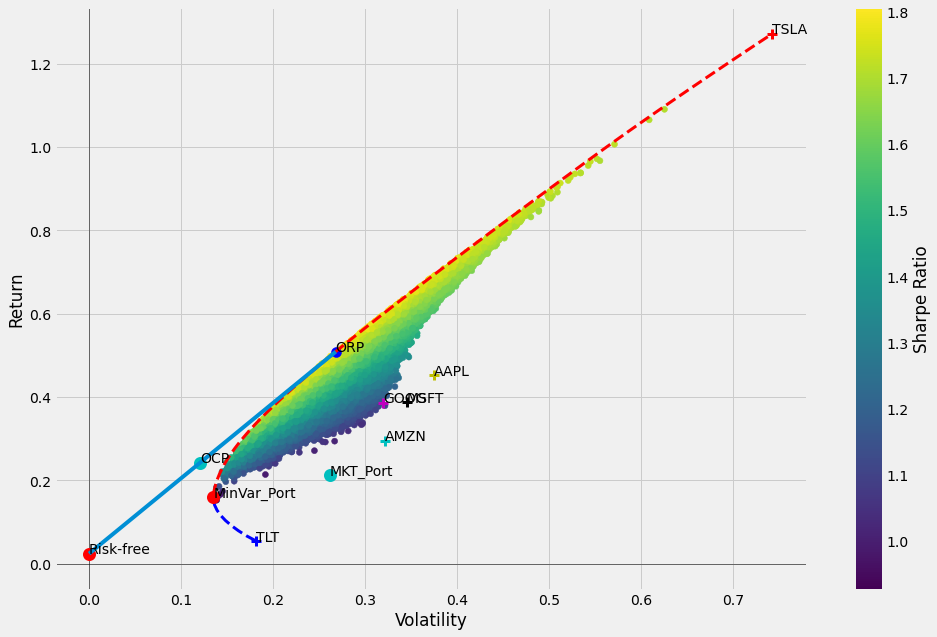

In [71]:
plt.style.use('fivethirtyeight')

plt.figure(figsize=(15,10))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.scatter(maxsrvol, maxsrret,c='blue', s=100)
plt.text(maxsrvol,maxsrret,"ORP")

plt.plot(Effrontier_x,Effrontier_y, 'r--', linewidth=3)
plt.plot(ineff_x,ineff_y, 'b--', linewidth=3)

plt.axhline(0,0,c="black",lw=0.5)
plt.axvline(0,0,c="black",lw=0.5)


# Market ETF
plt.plot(mktrisk,mktreturns,'co', markersize = 10, markeredgewidth=3)
plt.text(mktrisk,mktreturns,s="MKT_Port")
# Minimum Variance Port
plt.plot(minvarvol,minvarret,'ro', markersize = 10, markeredgewidth=3)
plt.text(minvarvol,minvarret,s="MinVar_Port")

# Risk-free asset
plt.plot(0,rf,'ro', markersize = 10, markeredgewidth=3)
plt.text(0,rf,"Risk-free")

colorshape = ['y+','k+','m+','c+','r+','b+','yo','go','co','mo']
for t in tickers:
    plt.plot(vol[t],ret[t],colorshape[tickers.index(t)],markersize = 10, markeredgewidth=3)
    plt.text(vol[t],ret[t],t)
    print(t, "|", colorshape[tickers.index(t)], 
          "| Returns: {}%".format(round(ret[t]*100,2)), 
          "Risk: {}%".format(round(vol[t]*100,2)),
          "SR: {}".format(round(sr[t],2))
         )

#Optimal Complete Portfolio
A = 15
OCP = OptimalComplete_y_ret_vol(A,maxsrret,maxsrvol)
OCP_ret = OCP[1]
OCP_vol = OCP[2]
plt.plot(OCP_vol,OCP_ret,'co', markersize = 10, markeredgewidth=3)
plt.text(OCP_vol,OCP_ret,s="OCP")
print("risky asset: {}%".format(round(OCP[0]*100)), "risk-free asset: {}%".format(round((1-OCP[0])*100)))


# Best feasible CAL
x_domain = max(maxsrvol,OCP_vol)
risky = np.linspace(0,x_domain,200)
y = rf + maxsr*risky
plt.plot(risky, y)


#plt.show()
plt.savefig("output.jpg")

In [78]:
print('Max sharpe ratio in the array: {}'.format(sharpe_arr.max()), maxsr, maxsr > sharpe_arr.max())
print('Min variance in the array: {}'.format(vol_arr.min()), minvarvol, minvarvol < vol_arr.min())
print('SR of OCP:', sharpe(OCP_vol,OCP_ret))

Max sharpe ratio in the array: 1.8074655313873396 1.8090175925107017 True
Min variance in the array: 0.1383326843503716 0.13480325084560568 True
SR of OCP: 1.809017592510702
